In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d {'chiragsaipanuganti/morph'} -p /content/dataset

Dataset URL: https://www.kaggle.com/datasets/chiragsaipanuganti/morph
License(s): GNU Affero General Public License 3.0


In [ ]:
! unzip /content/dataset/morph.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Dataset/Images/Validation/00232_03F24.JPG  
  inflating: /content/dataset/Dataset/Images/Validation/00260_03M23.JPG  
  inflating: /content/dataset/Dataset/Images/Validation/00308_02M36.JPG  
  inflating: /content/dataset/Dataset/Images/Validation/00308_04M37.JPG  
  inflating: /content/dataset/Dataset/Images/Validation/00370_2M35.JPG  
  inflating: /content/dataset/Dataset/Images/Validation/0054_05M45.JPG  
  inflating: /content/dataset/Dataset/Images/Validation/00620_01F29.JPG  
  inflating: /content/dataset/Dataset/Images/Validation/00744_24M39.JPG  
  inflating: /content/dataset/Dataset/Images/Validation/00881_02M27.JPG  
  inflating: /content/dataset/Dataset/Images/Validation/0089_01F38.JPG  
  inflating: /content/dataset/Dataset/Images/Validation/0089_03F38.JPG  
  inflating: /content/dataset/Dataset/Images/Validation/00907_1M34.JPG  
  inflating: /content/dataset/Dataset/Images/Validation/01015_00M4

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import os
import numpy as np
from tqdm import tqdm

# Config
config = {
    'image_size': 128,
    'batch_size': 45,
    'latent_dim': 100,
    'lr': 0.0001,
    'beta1': 0.5,
    'epochs': 10,
    'triplet_margin': 0.3,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

if torch.cuda.is_available():
  torch.cuda.empty_cache()

In [ ]:
PATHS = ["./dataset/Dataset/Index/Train.csv",
         "./dataset/Dataset/Index/Validation.csv",
         "./dataset/Dataset/Index/Test.csv"]

for FILE_PATH in PATHS:
  df = pd.read_csv(FILE_PATH)
  df["subject_id"] = df["filename"].apply(lambda x: x.split("_")[0])
  df.drop('filepath', axis=1, inplace=True)
  # df.drop('Unnamed: 0.1', axis=1, inplace=True)
  df.to_csv(FILE_PATH, index=False)

In [ ]:
# Dataset Class
class MorphDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        # Create identity to image mapping
        self.id_to_images = self.annotations.groupby('subject_id')['filename'].apply(list).to_dict()

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 2])
        image = Image.open(img_name).convert('RGB')
        age = self.annotations.iloc[idx, 0]
        gender = self.annotations.iloc[idx, 1]
        subject_id = self.annotations.iloc[idx, 3]

        if self.transform:
            image = self.transform(image)

        # Get positive sample (same identity)
        same_id_images = self.id_to_images[subject_id]
        if len(same_id_images) > 1:
            # Exclude current image
            same_id_images = [x for x in same_id_images if x != self.annotations.iloc[idx, 2]]
            positive_img_name = np.random.choice(same_id_images)
            positive_img = Image.open(os.path.join(self.root_dir, positive_img_name)).convert('RGB')
            positive_img = self.transform(positive_img)
        else:
            positive_img = image.clone()

        return {
            'image': image,
            'age': torch.tensor(age, dtype=torch.float32),
            'gender': torch.tensor(gender, dtype=torch.long),
            'subject_id': subject_id,
            'positive_img': positive_img
        }

In [ ]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((config['image_size'], config['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Initialize dataset and dataloader
dataset = MorphDataset(csv_file="./dataset/Dataset/Index/Train.csv", root_dir="./dataset/Dataset/Images/Train", transform=transform)
dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim

        self.model = nn.Sequential(
            # Input: latent_dim + age (1) + gender (1) = latent_dim + 2
            nn.Linear(latent_dim + 2, 256 * 8 * 8),
            nn.BatchNorm1d(256 * 8 * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Unflatten(1, (256, 8, 8)),

            # Upsample to 16x16
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Upsample to 32x32
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # Upsample to 64x64
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),

            # Upsample to 128x128
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z, age, gender):
        # Concatenate latent vector with age and gender
        age_gender = torch.cat([age.unsqueeze(1), gender.unsqueeze(1).float()], dim=1)
        z = torch.cat([z, age_gender], dim=1)
        return self.model(z)

In [ ]:
from torchvision.models import mobilenet_v3_large, resnet152, resnet18
from transformers import ViTModel

class Discriminator(nn.Module):
    def __init__(self, base_model='resnet152'):
        super(Discriminator, self).__init__()
        self.base_model_name = base_model

        # Initialize base model
        if base_model == 'resnet18':
            self.base_model = resnet18(pretrained=True)
            # Remove final classification layer
            self.features = nn.Sequential(*list(self.base_model.children())[:-1])
            self.feature_dim = 512  # ResNet18 feature dimension

        # Initialize base model
        elif base_model == 'resnet152':
            self.base_model = resnet152(pretrained=True)
            # Remove final classification layer
            self.features = nn.Sequential(*list(self.base_model.children())[:-1])
            self.feature_dim = 2048  # ResNet152 feature dimension

        elif base_model == 'mobilenet_v3':
            self.base_model = mobilenet_v3_large(pretrained=True)
            # Remove classifier and avgpool, keep features
            self.features = self.base_model.features
            self.features.avgpool = nn.Identity()  # Remove original avgpool
            self.feature_dim = 960  # MobileNetV3 feature dimension
            # Add custom pooling
            self.pool = nn.AdaptiveAvgPool2d(1)

        elif base_model == 'dinov2_vit':
            self.base_model = ViTModel.from_pretrained('facebook/dinov2-base')
            self.feature_dim = 768  # DINOv2 base feature dimension
            # Freeze all layers except last few
            for param in self.base_model.parameters():
                param.requires_grad = False
            # Unfreeze last transformer blocks
            for block in self.base_model.encoder.layer[-4:]:
                for param in block.parameters():
                    param.requires_grad = True
        else:
            raise ValueError(f"Unknown base model: {base_model}")

        # Age regression head
        self.age_head = nn.Sequential(
            nn.Linear(self.feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

        # Identity feature head
        self.id_head = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512)
        )

        # Real/Fake classification head
        self.gan_head = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

        # Initialize weights for heads
        self._init_weights()

    def _init_weights(self):
        for m in [self.age_head, self.id_head, self.gan_head]:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        if self.base_model_name == 'resnet152':
            features = self.features(x)
            features = features.view(features.size(0), -1)

        elif self.base_model_name == 'mobilenet_v3':
            features = self.features(x)
            features = self.pool(features)
            features = features.view(features.size(0), -1)

        elif self.base_model_name == 'dinov2_vit':
            # ViT expects 3x224x224 input
            if x.shape[-2:] != (224, 224):
                x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
            outputs = self.base_model(pixel_values=x)
            features = outputs.last_hidden_state[:, 0, :]  # CLS token

        return features

    def forward(self, x):
        features = self.forward_features(x)

        age = self.age_head(features)
        id_features = self.id_head(features)
        gan_output = self.gan_head(features)

        return gan_output, age, id_features


In [ ]:
# Initialize models
generator = Generator(config['latent_dim']).to(config['device'])
discriminator = Discriminator("resnet152").to(config['device'])

# Loss functions
gan_loss = nn.BCELoss()
age_loss = nn.MSELoss()
triplet_loss = nn.TripletMarginLoss(margin=config['triplet_margin'])

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 173MB/s]


In [ ]:
# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=config['lr'], betas=(config['beta1'], 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=config['lr'], betas=(config['beta1'], 0.999))

In [ ]:
def visualize_batch(real_images, gen_images, positive_images, num_samples=5):
    """
    Display a comparison of real, generated, and positive samples

    Args:
        real_images: Batch of real images (Tensor)
        gen_images: Batch of generated images (Tensor)
        positive_images: Batch of positive samples (Tensor)
        num_samples: Number of samples to display
    """
    # Denormalize images
    def denorm(img):
        return img * 0.5 + 0.5  # [-1, 1] -> [0, 1]

    # Convert to numpy and change to HWC format
    real_images = denorm(real_images[:num_samples]).cpu().permute(0, 2, 3, 1).numpy()
    gen_images = denorm(gen_images[:num_samples]).cpu().permute(0, 2, 3, 1).numpy()
    positive_images = denorm(positive_images[:num_samples]).cpu().permute(0, 2, 3, 1).numpy()

    # Create figure
    plt.figure(figsize=(15, 5))
    plt.suptitle("Training Batch Samples (Real/Generated/Positive)", y=1.05)

    for i in range(num_samples):
        # Real image
        plt.subplot(3, num_samples, i+1)
        plt.imshow(real_images[i])
        plt.title(f"Real {i+1}")
        plt.axis('off')

        # Generated image
        plt.subplot(3, num_samples, num_samples + i+1)
        plt.imshow(gen_images[i])
        plt.title(f"Generated {i+1}")
        plt.axis('off')

        # Positive image
        plt.subplot(3, num_samples, 2*num_samples + i+1)
        plt.imshow(positive_images[i])
        plt.title(f"Positive {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Add this to your training loop after generating images:
if epoch % config.get('sample_interval', 5) == 0 and i == 0:  # First batch of every N epochs
    visualize_batch(real_images, fake_images, positive_images, num_samples=5)

Epoch 1/1:   0%|          | 0/890 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


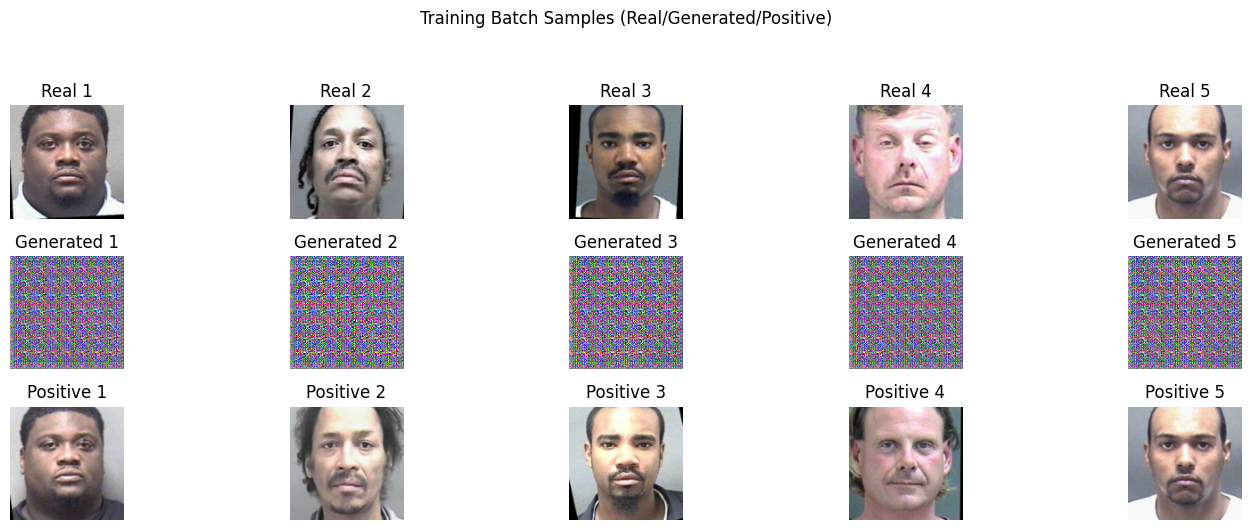

Epoch 1/1:   0%|          | 0/890 [00:02<?, ?it/s]


ZeroDivisionError: float division by zero

In [ ]:
import matplotlib.pyplot as plt
config['epochs'] = 1
generator.train()
discriminator.train()

# Modified training loop for multi-backbone support
for epoch in range(config['epochs']):
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{config["epochs"]}')

    # Initialize metrics
    epoch_triplet_acc = 0.0
    epoch_pos_dist = 0.0
    epoch_neg_dist = 0.0
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    epoch_t_loss = 0.0
    num_batches = 0

    generator.eval()
    discriminator.eval()
    for i, batch in enumerate(progress_bar):
        real_images = batch['image'].to(config['device'])
        ages = batch['age'].to(config['device'])
        genders = batch['gender'].to(config['device'])
        positive_images = batch['positive_img'].to(config['device'])
        batch_size = real_images.size(0)

        # Adversarial ground truths
        valid = torch.ones(batch_size, 1).to(config['device'])
        fake = torch.zeros(batch_size, 1).to(config['device'])

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real images
        real_gan, real_age, real_id = discriminator(real_images)
        d_real_loss = gan_loss(real_gan, valid) + age_loss(real_age.squeeze(), ages)

        # Generate fake images
        z = torch.randn(batch_size, config['latent_dim']).to(config['device'])
        fake_images = generator(z, ages, genders)

        visualize_batch(real_images.detach(), fake_images.detach(), positive_images.detach())

        break

        # Fake images
        fake_gan, _, _ = discriminator(fake_images.detach())
        d_fake_loss = gan_loss(fake_gan, fake)

        # Triplet loss components
        rand_idx = torch.randperm(batch_size)
        negative_images = real_images[rand_idx]

        # Get identity features - architecture-specific handling
        if discriminator.base_model in ['resnet18', 'resnet152', 'mobilenet_v3']:
            # For CNN models
            anchor_features = discriminator.id_head(discriminator.forward_features(real_images))
            positive_features = discriminator.id_head(discriminator.forward_features(positive_images))
            negative_features = discriminator.id_head(discriminator.forward_features(negative_images))
        else:
            # For ViT model
            anchor_features = discriminator.id_head(discriminator.forward_features(real_images))
            positive_features = discriminator.id_head(discriminator.forward_features(positive_images))
            negative_features = discriminator.id_head(discriminator.forward_features(negative_images))

        # Calculate distances for metrics
        pos_dist = torch.norm(anchor_features - positive_features, p=2, dim=1)
        neg_dist = torch.norm(anchor_features - negative_features, p=2, dim=1)

        # Calculate triplet accuracy
        correct_triplets = (pos_dist + config['triplet_margin'] < neg_dist).float().mean()
        epoch_triplet_acc += correct_triplets.item()
        epoch_pos_dist += pos_dist.mean().item()
        epoch_neg_dist += neg_dist.mean().item()
        num_batches += 1

        # Compute triplet loss
        t_loss = triplet_loss(anchor_features, positive_features, negative_features)
        epoch_t_loss += t_loss.item()

        # Total discriminator loss
        d_loss = d_real_loss + d_fake_loss + t_loss
        epoch_d_loss += d_loss.item()
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Generate fake images
        gen_images = generator(z, ages, genders)

        # Generator wants discriminator to think these are real
        gen_gan, gen_age, _ = discriminator(gen_images)
        g_loss = gan_loss(gen_gan, valid) + age_loss(gen_age.squeeze(), ages)
        epoch_g_loss += g_loss.item()

        # Optional: Add feature matching loss for generator
        if config.get('use_feature_matching', False):
            _, _, real_id = discriminator(real_images)
            _, _, gen_id = discriminator(gen_images)
            fm_loss = F.mse_loss(gen_id, real_id.detach())
            g_loss += fm_loss * config.get('fm_weight', 0.1)

        g_loss.backward()
        optimizer_G.step()

        # Update progress bar
        progress_bar.set_postfix({
            'D Loss': d_loss.item(),
            'G Loss': g_loss.item(),
            'Triplet Loss': t_loss.item(),
            'Acc': correct_triplets.item()
        })

    # Calculate epoch metrics
    epoch_triplet_acc /= num_batches
    epoch_pos_dist /= num_batches
    epoch_neg_dist /= num_batches
    epoch_d_loss /= num_batches
    epoch_g_loss /= num_batches
    epoch_t_loss /= num_batches

    print(f"\nEpoch {epoch+1} Metrics:")
    print(f"Triplet Accuracy: {epoch_triplet_acc:.4f}")
    print(f"Avg Positive Distance: {epoch_pos_dist:.4f}")
    print(f"Avg Negative Distance: {epoch_neg_dist:.4f}")
    print(f"Distance Ratio (neg/pos): {epoch_neg_dist/epoch_pos_dist:.4f}")
    print(f"Discriminator Loss: {epoch_d_loss:.4f}")
    print(f"Generator Loss: {epoch_g_loss:.4f}")
    print(f"Triplet Loss: {epoch_t_loss:.4f}")

    # Visualize samples periodically
    if epoch % config.get('sample_interval', 5) == 0:
        with torch.no_grad():
            # Generate samples
            sample_z = torch.randn(5, config['latent_dim']).to(config['device'])
            sample_ages = torch.linspace(0, 1, 5).to(config['device'])
            sample_genders = torch.randint(0, 2, (5,)).to(config['device'])
            gen_samples = generator(sample_z, sample_ages, sample_genders)

            # Plot samples
            plt.figure(figsize=(15, 3))
            for j in range(5):
                plt.subplot(1, 5, j+1)
                plt.imshow(gen_samples[j].cpu().permute(1, 2, 0) * 0.5 + 0.5)
                plt.title(f"Age: {sample_ages[j].item():.2f}, Gen: {sample_genders[j].item()}")
                plt.axis('off')
            plt.show()

In [ ]:
# Save models

MODEL_NAME = "model2"

torch.save(generator.to('cpu').state_dict(), f'Models/{MODEL_NAME}/generator.pth')
torch.save(discriminator.to('cpu').state_dict(), f'Models/{MODEL_NAME}/discriminator.pth')

generator.to(config['device'])
discriminator.to(config['device'])

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Evaluating: 100%|██████████| 112/112 [00:47<00:00,  2.37it/s]
<ipython-input-21-a0e46aae248a>:142: RuntimeWarning: Mean of empty slice.
  ratio_by_age = [distance_ratios[age_bin_indices == i].mean() for i in range(len(age_bins)-1)]
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-21-a0e46aae248a>:160: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seabo


Test Set Metrics:
Triplet Accuracy: 0.9248
Avg Pos Distance: 0.2044
Avg Neg Distance: 1.6339
Gan Loss: 0.1466
Age Loss: 361.2905
Triplet Loss: 0.0288
Distance Ratio: 7.9940


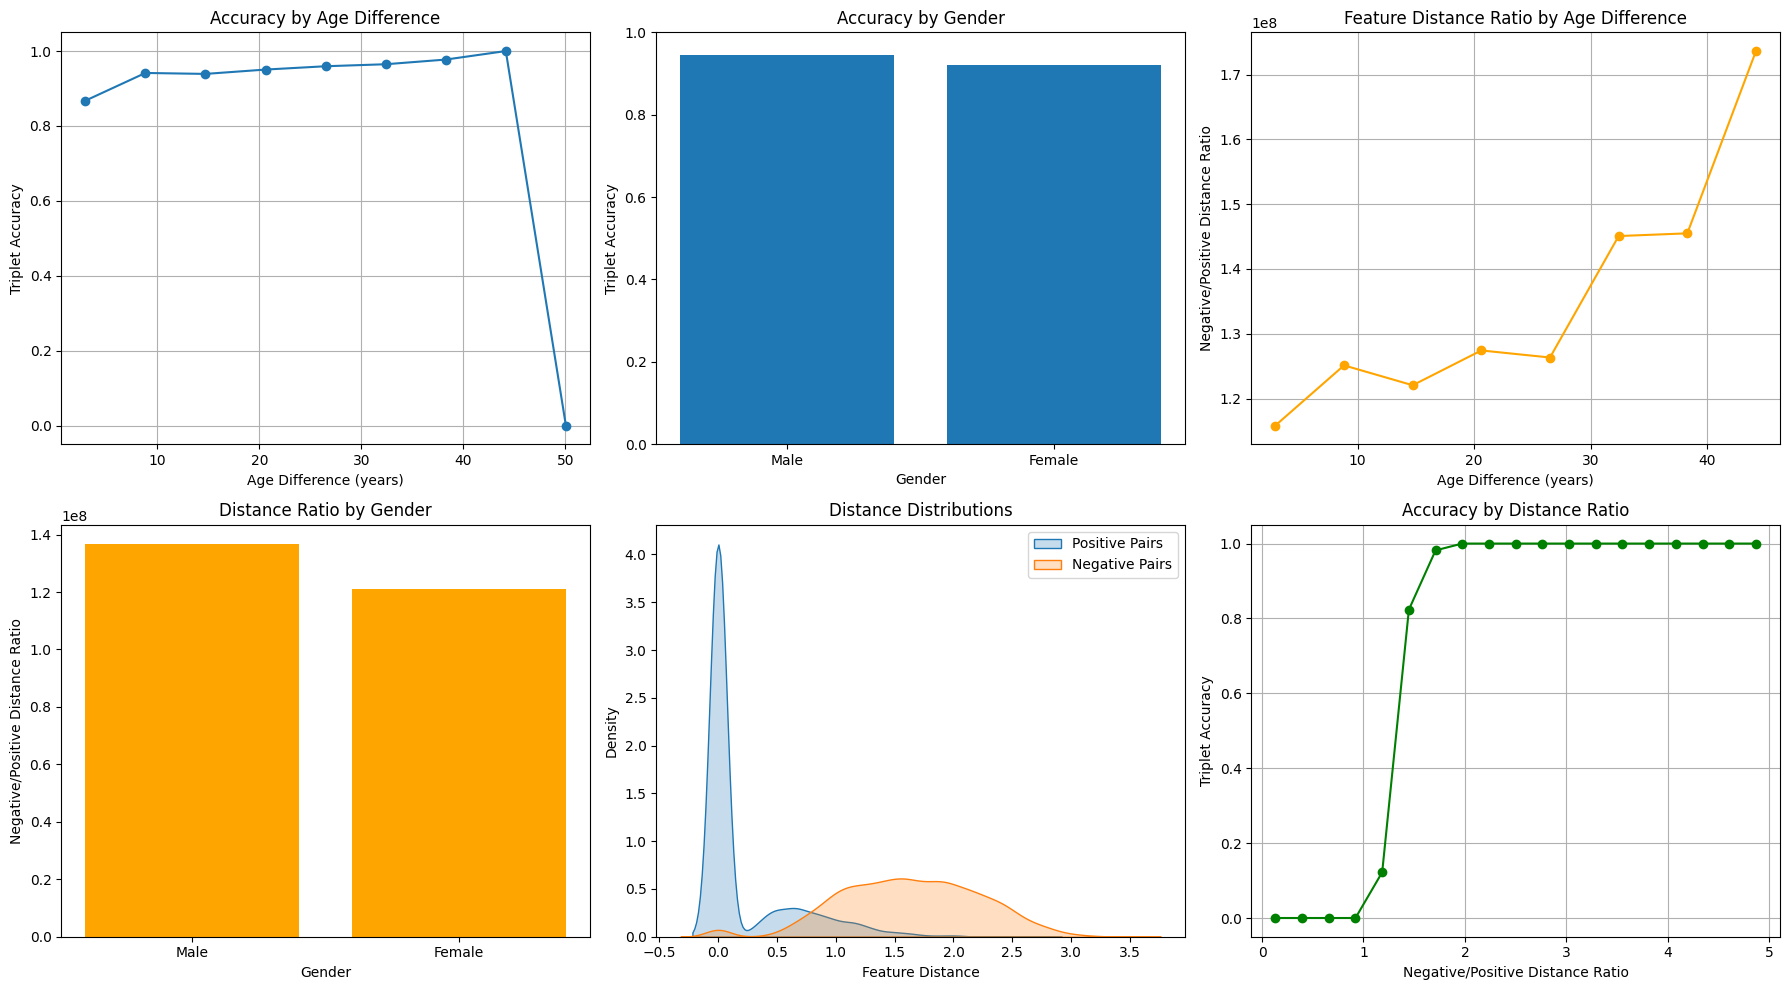

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

def evaluate_model(test_loader, generator, discriminator, config):
    discriminator.eval()
    generator.eval()

    # Initialize metrics
    total_triplet_acc = 0.0
    total_pos_dist = 0.0
    total_neg_dist = 0.0
    total_gan_loss = 0.0
    total_age_loss = 0.0
    total_triplet_loss = 0.0

    # For age/gender analysis
    age_diffs = []
    genders = []
    correct_preds = []
    distances_pos = []
    distances_neg = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Evaluating'):
            real_images = batch['image'].to(config['device'])
            ages = batch['age'].to(config['device'])
            genders_batch = batch['gender'].to(config['device'])
            positive_images = batch['positive_img'].to(config['device'])
            batch_size = real_images.size(0)

            # Get features and predictions
            real_gan, real_age, real_id = discriminator(real_images)

            # Get negative samples (different identity)
            rand_idx = torch.randperm(batch_size)
            negative_images = real_images[rand_idx]

            #positive_features = discriminator.id_head(discriminator.features(positive_images).view(batch_size, -1))
            #negative_features = discriminator.id_head(discriminator.features(negative_images).view(batch_size, -1))

            # Get identity features - architecture-specific handling
            if discriminator.base_model in ['resnet152', 'mobilenet_v3']:
                # For CNN models
                anchor_features = discriminator.id_head(discriminator.forward_features(real_images))
                positive_features = discriminator.id_head(discriminator.forward_features(positive_images))
                negative_features = discriminator.id_head(discriminator.forward_features(negative_images))
            else:
                # For ViT model
                anchor_features = discriminator.id_head(discriminator.forward_features(real_images))
                positive_features = discriminator.id_head(discriminator.forward_features(positive_images))
                negative_features = discriminator.id_head(discriminator.forward_features(negative_images))

            # Calculate distances
            pos_dist = torch.norm(real_id - positive_features, p=2, dim=1)
            neg_dist = torch.norm(real_id - negative_features, p=2, dim=1)

            # Calculate metrics
            correct = (pos_dist + config['triplet_margin'] < neg_dist).float()
            triplet_acc = correct.mean()

            # Store for age/gender analysis
            age_diffs.extend(torch.abs(ages - batch['age'][rand_idx].to(config['device'])).cpu().numpy())
            genders.extend(genders_batch.cpu().numpy())
            correct_preds.extend(correct.cpu().numpy())
            distances_pos.extend(pos_dist.cpu().numpy())
            distances_neg.extend(neg_dist.cpu().numpy())

            # Calculate losses
            valid = torch.ones(batch_size, 1).to(config['device'])
            gan_loss_val = gan_loss(real_gan, valid)
            age_loss_val = age_loss(real_age.squeeze(), ages)
            triplet_loss_val = triplet_loss(real_id, positive_features, negative_features)

            # Accumulate metrics
            total_triplet_acc += triplet_acc.item()
            total_pos_dist += pos_dist.mean().item()
            total_neg_dist += neg_dist.mean().item()
            total_gan_loss += gan_loss_val.item()
            total_age_loss += age_loss_val.item()
            total_triplet_loss += triplet_loss_val.item()

    # Calculate averages
    num_batches = len(test_loader)
    metrics = {
        'triplet_accuracy': total_triplet_acc / num_batches,
        'avg_pos_distance': total_pos_dist / num_batches,
        'avg_neg_distance': total_neg_dist / num_batches,
        'gan_loss': total_gan_loss / num_batches,
        'age_loss': total_age_loss / num_batches,
        'triplet_loss': total_triplet_loss / num_batches,
        'distance_ratio': (total_neg_dist / num_batches) / (total_pos_dist / num_batches)
    }

    # Convert to numpy for plotting
    age_diffs = np.array(age_diffs)
    genders = np.array(genders)
    correct_preds = np.array(correct_preds)
    distances_pos = np.array(distances_pos)
    distances_neg = np.array(distances_neg)

    return metrics, (age_diffs, genders, correct_preds, distances_pos, distances_neg)

def plot_performance(analysis_data):
    age_diffs, genders, correct_preds, distances_pos, distances_neg = analysis_data

    plt.figure(figsize=(18, 10))

    # 1. Age Difference vs Accuracy
    plt.subplot(2, 3, 1)
    age_bins = np.linspace(0, age_diffs.max(), 10)
    age_bin_centers = (age_bins[:-1] + age_bins[1:]) / 2
    bin_accuracies = []

    for i in range(len(age_bins)-1):
        mask = (age_diffs >= age_bins[i]) & (age_diffs < age_bins[i+1])
        if mask.sum() > 0:
            bin_accuracies.append(correct_preds[mask].mean())
        else:
            bin_accuracies.append(0)

    plt.plot(age_bin_centers, bin_accuracies, marker='o')
    plt.xlabel('Age Difference (years)')
    plt.ylabel('Triplet Accuracy')
    plt.title('Accuracy by Age Difference')
    plt.grid(True)

    # 2. Gender vs Accuracy
    plt.subplot(2, 3, 2)
    gender_labels = ['Male', 'Female']
    gender_acc = [correct_preds[genders == i].mean() for i in range(2)]
    plt.bar(gender_labels, gender_acc)
    plt.xlabel('Gender')
    plt.ylabel('Triplet Accuracy')
    plt.title('Accuracy by Gender')
    plt.ylim(0, 1)

    # 3. Age Difference vs Distance Ratio
    plt.subplot(2, 3, 3)
    distance_ratios = distances_neg / (distances_pos + 1e-8)
    age_bin_indices = np.digitize(age_diffs, age_bins) - 1
    ratio_by_age = [distance_ratios[age_bin_indices == i].mean() for i in range(len(age_bins)-1)]

    plt.plot(age_bin_centers, ratio_by_age, marker='o', color='orange')
    plt.xlabel('Age Difference (years)')
    plt.ylabel('Negative/Positive Distance Ratio')
    plt.title('Feature Distance Ratio by Age Difference')
    plt.grid(True)

    # 4. Gender vs Distance Ratio
    plt.subplot(2, 3, 4)
    gender_ratios = [distance_ratios[genders == i].mean() for i in range(2)]
    plt.bar(gender_labels, gender_ratios, color='orange')
    plt.xlabel('Gender')
    plt.ylabel('Negative/Positive Distance Ratio')
    plt.title('Distance Ratio by Gender')

    # 5. Distance Distributions
    plt.subplot(2, 3, 5)
    sns.kdeplot(distances_pos, label='Positive Pairs', shade=True)
    sns.kdeplot(distances_neg, label='Negative Pairs', shade=True)
    plt.xlabel('Feature Distance')
    plt.ylabel('Density')
    plt.title('Distance Distributions')
    plt.legend()

    # 6. Accuracy vs Distance Ratio
    plt.subplot(2, 3, 6)
    ratio_bins = np.linspace(0, 5, 20)
    ratio_bin_centers = (ratio_bins[:-1] + ratio_bins[1:]) / 2
    ratio_acc = []

    for i in range(len(ratio_bins)-1):
        mask = (distance_ratios >= ratio_bins[i]) & (distance_ratios < ratio_bins[i+1])
        if mask.sum() > 0:
            ratio_acc.append(correct_preds[mask].mean())

    plt.plot(ratio_bin_centers[:len(ratio_acc)], ratio_acc, marker='o', color='green')
    plt.xlabel('Negative/Positive Distance Ratio')
    plt.ylabel('Triplet Accuracy')
    plt.title('Accuracy by Distance Ratio')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Transformations
test_transform = transforms.Compose([
    transforms.Resize((config['image_size'], config['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Initialize dataset and dataloader
test_dataset = MorphDataset(csv_file="./dataset/Dataset/Index/Test.csv", root_dir="./dataset/Dataset/Images/Test", transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=4)

# Usage Example:
# Assuming you have test_loader defined
test_metrics, analysis_data = evaluate_model(test_loader, generator, discriminator, config)

print("\nTest Set Metrics:")
for k, v in test_metrics.items():
    print(f"{k.replace('_', ' ').title()}: {v:.4f}")

plot_performance(analysis_data)